In [3]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%autoreload 2
from delase import *
from matplotlib.colors import TwoSlopeNorm
import numpy as np
from tqdm.auto import tqdm

from demo_utils import rnn, compute_lyaps_and_jacobians


In [68]:
N = 1024
T = 20000
dt = 0.001
tau = 0.01

g_vals = [1, 1.1]

In [69]:
def g_dW(x):
    return 0.05

signals = {}
lyaps = {}

np.random.seed(42)

print("Simulating signals...")
W = np.random.randn(N, N)/np.sqrt(N)
for g in tqdm(g_vals):
    dW = np.sqrt(dt) * np.random.randn(T,N)
    x0 = np.random.randn(N)
        # Define the function g(x)
    

    # Initialize the x array
    x = np.zeros((T, N))
    x[0] = np.random.randn(N)

    # Simulate the stochastic differential equation
    for i in tqdm(range(1, T)):
        x[i] = x[i-1] + rnn((i - 1)*dt, x[i-1], W, tau, g) * dt + g_dW(x[i-1]) * dW[i]
        
    signals[g] = x

    # lyaps[g] = compute_lyaps_and_jacobians(signals[g], W, g, tau, dt, N, k=3, use_torch=False, device='cpu', verbose=True)
print("Signals simulated!")

Simulating signals...


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/19999 [00:00<?, ?it/s]

  0%|          | 0/19999 [00:00<?, ?it/s]

Signals simulated!


In [72]:
colors = ['skyblue', 'salmon']
param_name = 'g'

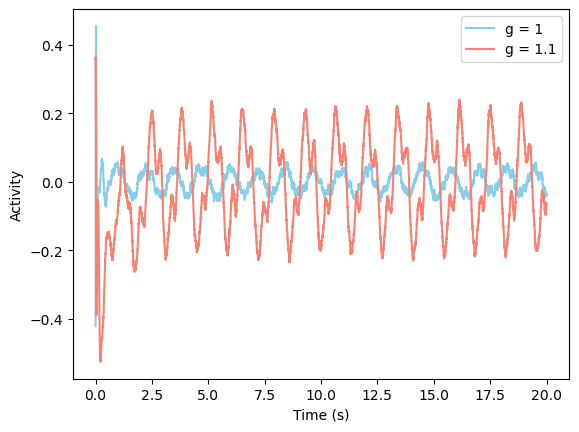

In [73]:
for i, g in enumerate(g_vals):
    plt.plot(np.arange(T)*dt, signals[g][:, 0], color=colors[i], label=f"g = {g}")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Activity")
plt.show()

In [74]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

max_freq = (1/(dt))/2 # the maximum frequency that can be detected in the data is the Nyquist frequency - thus we filter out all delay differential equation roots with a frequency greater than this value

prediction_time = 4000
transient = 2000
window = 10000

num_indices = 2

n_delays_vals = np.array([1, 2, 3, 4, 5, 6, 7])
rank_vals = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

# n_delays_vals = np.array([1, 2, 5, 10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200])
# rank_vals = np.array([2, 3, 5, 10, 30, 40, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400])

np.random.seed(42)


all_delase_results = []

num_trajs = 1

iterator = tqdm(total=num_trajs*len(g_vals)*len(n_delays_vals)*len(rank_vals))

train_inds = np.arange(transient, transient + window)
test_inds = np.arange(transient + window, transient + window + prediction_time)

for num_traj in range(num_trajs):
    # print("-"*20)
    # print(f"NUM_TRAJ = {num_traj}")
    delase_results = {}
    
    for g in g_vals:

        x = signals[g]
        indices = np.random.choice(np.arange(N), size=(num_indices, ), replace=False)
        x = x[:, indices]
        
        aic_mat = np.zeros((len(n_delays_vals), len(rank_vals)))
        mase_mat = np.zeros((len(n_delays_vals), len(rank_vals)))
        stab_mean_mat2 = np.zeros((len(n_delays_vals), len(rank_vals)))
        stab_mean_mat10p = np.zeros((len(n_delays_vals), len(rank_vals)))
        delase_evals_mat2 = np.zeros((len(n_delays_vals), len(rank_vals)))
        delase_evals_mat10p = np.zeros((len(n_delays_vals), len(rank_vals)))
        
        for i, n_delays in enumerate(n_delays_vals):
            delase = DeLASE(torch.from_numpy(x[train_inds]).to(device), n_delays=n_delays, rank=n_delays*x.shape[-1], dt=dt, max_freq=max_freq, max_unstable_freq=max_freq, device=device)
            delase.DMD.compute_hankel()
            delase.DMD.compute_svd()
            for j, rank in enumerate(rank_vals):
                if rank <= n_delays*x.shape[-1]:
                    
                    delase.DMD.compute_havok_dmd(rank=rank)
                    preds = delase.DMD.predict(x[test_inds])
                    aic_mat[i, j] = float(aic(torch.from_numpy(x[test_inds]).cuda(), preds, k=rank**2).cpu().numpy())
                    mase_mat[i, j] = float(mase(torch.from_numpy(x[test_inds]).cuda(), preds).cpu().numpy())
                    delase.get_stability()
                    stab_mean_mat2[i, j] = delase.stability_params[:2].mean().cpu().numpy()
                    num_params = np.min((int(0.1*len(delase.stability_params)), rank))
                    num_params = np.max([num_params, 1])
                    stab_mean_mat10p[i, j] = delase.stability_params[:num_params].mean().cpu().numpy()

                    I = torch.eye(delase.DMD.A_havok_dmd.shape[0]).cuda()
                    evals = torch.linalg.eigvals((delase.DMD.A_havok_dmd - I)/dt)
                    evals, freqs = torch.real(evals), torch.imag(evals)/(2*np.pi)
                    sort_inds = torch.flip(torch.sort(evals).indices, dims=(0,))
                    evals, freqs = evals[sort_inds], freqs[sort_inds]
                    freq_inds = freqs <= max_freq
                    evals = evals[freq_inds]
                    freqs = freqs[freq_inds]
                    delase_evals_mat2[i, j] = evals[:2].mean().cpu().numpy()
                    num_evals = np.min((int(0.1*len(evals)), rank))
                    num_evals = np.max([num_evals, 1])
                    delase_evals_mat10p[i, j] = evals[:num_evals].mean().cpu().numpy()
                    
                else:
                    aic_mat[i, j] = np.inf
                    mase_mat[i, j] = np.inf
                iterator.update()
    
        delase_results[g] = dict(
            train_inds=train_inds,
            test_inds=test_inds,
            aic_mat=aic_mat,
            mase_mat=mase_mat,
            stab_mean_mat2=stab_mean_mat2,
            stab_mean_mat10p=stab_mean_mat10p,
            delase_evals_mat2=delase_evals_mat2,
            delase_evals_mat10p = delase_evals_mat10p
        )

    all_delase_results.append(delase_results)
    
iterator.close()

  0%|          | 0/182 [00:00<?, ?it/s]

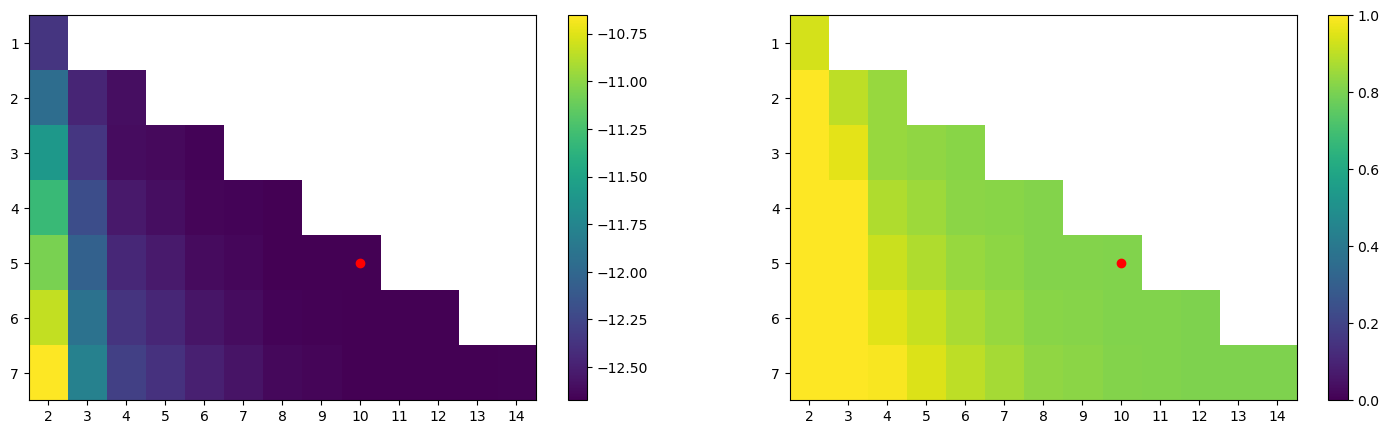

In [75]:
params_to_use = g_vals

aic_mat_all = np.ones((num_trajs, len(params_to_use), len(n_delays_vals), len(rank_vals)))
mase_mat_all = np.ones((num_trajs, len(params_to_use), len(n_delays_vals), len(rank_vals)))
for num_traj in range(num_trajs):
    delase_results = all_delase_results[num_traj]
    for ind, param in enumerate(params_to_use):
        aic_mat_all[num_traj, ind] = delase_results[param]['aic_mat']
        mase_mat_all[num_traj, ind] = delase_results[param]['mase_mat']
# aic_mat /= len(rhos_to_use)
aic_mat = aic_mat_all.mean(axis=(0, 1))
mase_mat = mase_mat_all.mean(axis=(0, 1))
i, j = np.unravel_index(aic_mat.argmin(), shape=aic_mat.shape)
# i, j = np.unravel_index(mase_mat.argmin(), shape=aic_mat.shape)
n_delays = n_delays_vals[i]
rank = rank_vals[j]
# n_delays = 200
# rank = 15
# rank = 12
# rank = 8
# j = np.where(np.array(rank_vals) == rank)[0][0]
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
ax = axs[0]
im = ax.imshow(aic_mat, aspect='auto')
ax.scatter(j, i, c='r')
ax.set_xticks(np.arange(len(rank_vals)), rank_vals)
ax.set_yticks(np.arange(len(n_delays_vals)), n_delays_vals)
fig.colorbar(im, ax=ax)

ax = axs[1]
norm = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
im = ax.imshow(mase_mat, aspect='auto', norm=norm)
ax.scatter(j, i, c='r')
ax.set_xticks(np.arange(len(rank_vals)), rank_vals)
ax.set_yticks(np.arange(len(n_delays_vals)), n_delays_vals)
fig.colorbar(im, ax=ax)

plt.show()

In [76]:
# Collect the results

stab_means_2 = np.zeros((num_trajs, len(params_to_use)))
stab_means_10p = np.zeros((num_trajs, len(params_to_use)))
delase_evals_2 = np.zeros((num_trajs, len(params_to_use)))
delase_evals_10p = np.zeros((num_trajs, len(params_to_use)))

for num_traj in range(num_trajs):
    delase_results = all_delase_results[num_traj]
    for ind, param in enumerate(params_to_use):
        stab_means_2[num_traj, ind] = delase_results[param]['stab_mean_mat2'][i, j]
        stab_means_10p[num_traj, ind] = delase_results[param]['stab_mean_mat10p'][i, j]
        delase_evals_2[num_traj, ind] = delase_results[param]['delase_evals_mat2'][i, j]
        delase_evals_10p[num_traj, ind] = delase_results[param]['delase_evals_mat10p'][i, j]

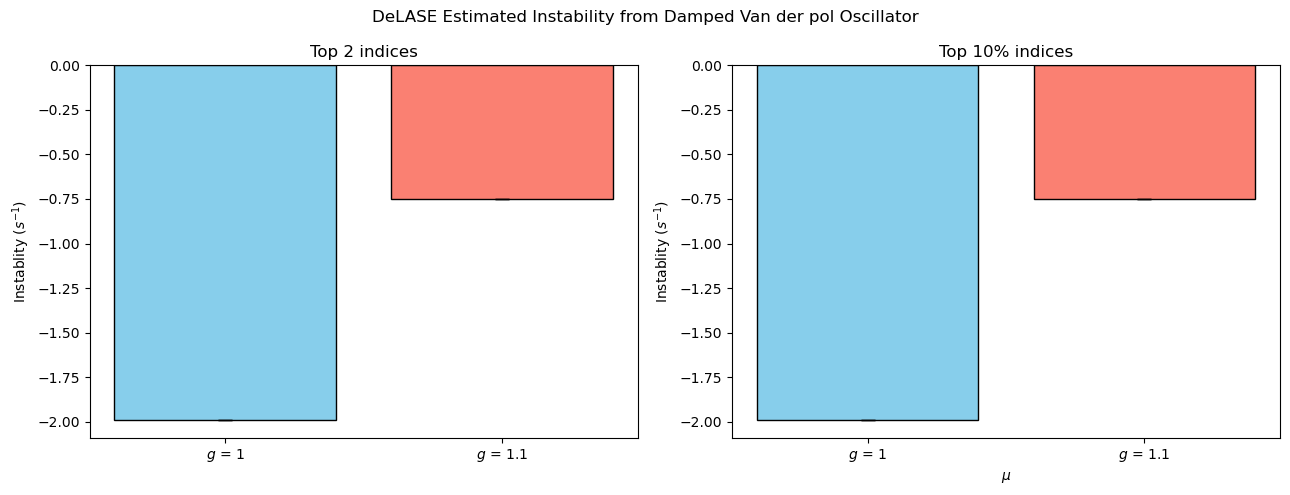

In [77]:


# Create the scatter plot with error bars

fig, axs = plt.subplots(1, 2, figsize=(13, 5))

ax = axs[0]
mean_vals = stab_means_2.mean(axis=0)
se_vals = stab_means_2.std(axis=0)/np.sqrt(stab_means_2.shape[0])
ax.bar(np.arange(len(params_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
ax.set_xticks(np.arange(len(params_to_use)), [fr"${param_name}$ = {param}" for param in params_to_use])

# ax.set_xlabel("$\mu$")
ax.set_ylabel("Instablity ($s^{-1}$)")
ax.set_title("Top 2 indices")

ax = axs[1]
mean_vals = stab_means_10p.mean(axis=0)
se_vals = stab_means_10p.std(axis=0)/np.sqrt(stab_means_10p.shape[0])
ax.bar(np.arange(len(params_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
ax.set_xticks(np.arange(len(params_to_use)), [fr"${param_name}$ = {param}" for param in params_to_use])

ax.set_xlabel("$\mu$")
ax.set_ylabel("Instablity ($s^{-1}$)")
ax.set_title("Top 10% indices")

fig.suptitle("DeLASE Estimated Instability from Damped Van der pol Oscillator")

# Create legend
plt.tight_layout()
plt.show()

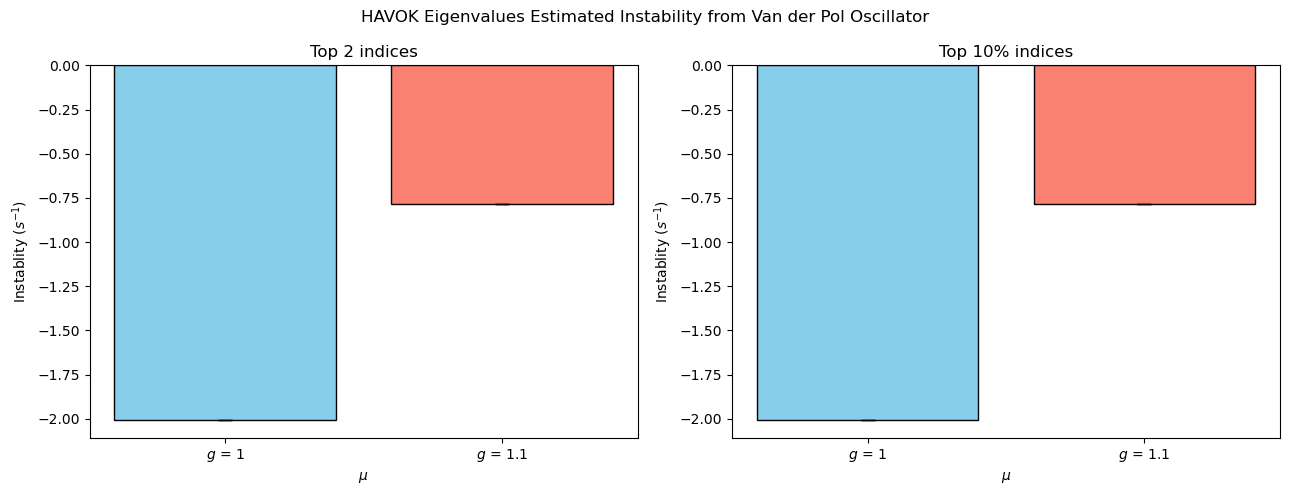

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

ax = axs[0]
mean_vals = delase_evals_2.mean(axis=0)
se_vals = delase_evals_2.std(axis=0)/np.sqrt(delase_evals_2.shape[0])
ax.bar(np.arange(len(params_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
ax.set_xticks(np.arange(len(params_to_use)), [fr"${param_name}$ = {param}" for param in params_to_use])

ax.set_xlabel("$\mu$")
ax.set_ylabel("Instablity ($s^{-1}$)")
ax.set_title("Top 2 indices")

ax = axs[1]
mean_vals = delase_evals_10p.mean(axis=0)
se_vals = delase_evals_10p.std(axis=0)/np.sqrt(delase_evals_10p.shape[0])
ax.bar(np.arange(len(params_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
ax.set_xticks(np.arange(len(params_to_use)), [fr"${param_name}$ = {param}" for param in params_to_use])

ax.set_xlabel("$\mu$")
ax.set_ylabel("Instablity ($s^{-1}$)")
ax.set_title("Top 10% indices")

fig.suptitle("HAVOK Eigenvalues Estimated Instability from Van der Pol Oscillator")

plt.tight_layout()
plt.show()

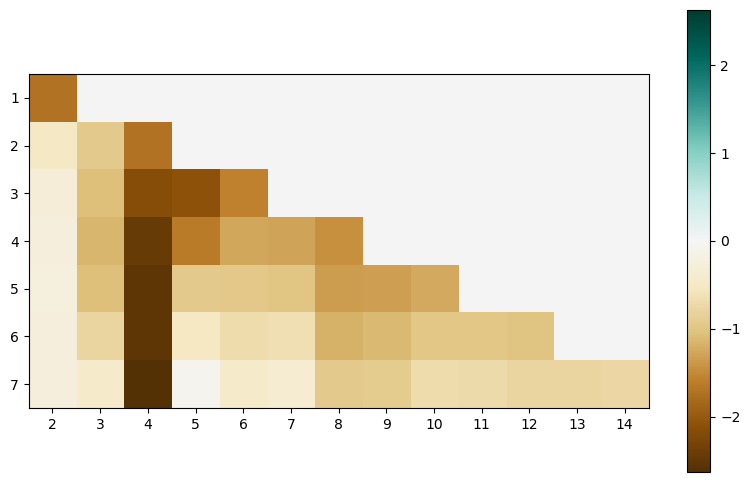

In [79]:
system1_ind = 0
system2_ind = 1

stab_means_all = np.zeros((num_trajs, len(params_to_use), len(n_delays_vals), len(rank_vals)))
# delase_evals_all = np.zeros((num_trajs, len(rhos_to_use), len(n_delays_vals), len(rank_vals)))
for i in range(len(n_delays_vals)):
    for j in range(len(rank_vals)):
        for num_traj in range(num_trajs):
            delase_results = all_delase_results[num_traj]
            for ind, param in enumerate(params_to_use):
                stab_means_all[num_traj, ind] = delase_results[param]['stab_mean_mat10p']
                # stab_means_all[num_traj, ind] = delase_results[param]['stab_mean_mat10p']
            

# fig, axs = plt.subplots(len(n_delays_vals), len(rank_vals), figsize=(20, 12))

stab_all_mean = stab_means_all.mean(axis=0)
stab_all_se = stab_means_all.std(axis=0)/np.sqrt(num_trajs)

diff = stab_all_mean[system1_ind] - stab_all_mean[system2_ind]
if diff.min() >= 0:
    norm = TwoSlopeNorm(vmin=-diff.max(), vcenter=0, vmax=diff.max())
elif diff.max() <= 0:
    norm = TwoSlopeNorm(vmin=diff.min(), vcenter=0, vmax=-diff.min())
else:
    norm = TwoSlopeNorm(vmin=diff.min(), vcenter=0, vmax=diff.max())
# norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
plt.figure(figsize=(10, 6))
plt.imshow(diff, cmap='BrBG', norm=norm)
plt.xticks(np.arange(len(rank_vals)), rank_vals)
plt.yticks(np.arange(len(n_delays_vals)), n_delays_vals)
plt.colorbar()

plt.show()